In [1]:
from model import *
from data_iterator import create_data_iterator
import latex_generator as gen
import png_latex

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

import numpy as np
import torch

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
latex_gen = gen.ExpressionGenerator(25)
to_tensor = tr.ToTensor()

In [4]:
PAD_IDX = latex_gen.token2id['<pad>']
START_IDX = latex_gen.token2id['<s>']
END_IDX = latex_gen.token2id['</s>']

In [5]:
vocab_size = len(latex_gen.tokens)

In [6]:
input_size = (1, 1, 200, 1000)
EMBEDDING_SIZE = 64
img = torch.rand(input_size)
cnn = CNN()
with torch.no_grad():
    output = cnn(img)
_, D, H, W = output.shape
enc = Encoder(D, H, W)

dec = Decoder(emb_size=EMBEDDING_SIZE,
              lstm_hidden_size=256, 
              att_hidden_size=128, 
              o_hidden_size=128,  
              memory_size=256, 
              output_size=vocab_size)

emb = Embedding(input_size=vocab_size, embedded_size=EMBEDDING_SIZE, padding_idx=latex_gen.token2id['<pad>'])
model = Model(cnn, enc, emb, dec).to(DEVICE)

In [7]:
model.load_state_dict(torch.load('model_34.pt', map_location=DEVICE))

<All keys matched successfully>

In [8]:
model.eval();

In [9]:
def get_input_img(img_name, n_ops):
    prefix = latex_gen.get_prefix_expr(n_ops)
    infix, _ = latex_gen.prefix_to_latex(prefix)
    img_name = png_latex.rasterise_formula(img_name, infix, dpi=200)
    img = Image.open(img_name)
    img.load()
    img_data = np.asarray(img)
    img_input = to_tensor(255 - img_data).unsqueeze(0)
    return img_input, prefix

In [10]:
def get_model_output(img_input, max_len=40):
    id_pred = model.generate_output(img_input, START_IDX, max_len)
    mask = id_pred != END_IDX
    token_pred = [latex_gen.id2token[v.item()] for v in id_pred[mask]]
    return token_pred[1:]

In [11]:
def make_pair(images_name, formula=None):
    if formula is not None:
        img_name = png_latex.rasterise_formula(images_name + '_true', formula, dpi=200)
        img = Image.open(img_name)
        img.load()
        img_data = np.asarray(img)
        img_input = to_tensor(255 - img_data).unsqueeze(0)
    else:
        img_input, true_target = get_input_img(images_name + '_true', 12)
    predicted_target = get_model_output(img_input)
    infix, _ = latex_gen.prefix_to_latex(predicted_target)
    pred_name = png_latex.rasterise_formula(images_name + '_pred', infix, dpi=200)
    true_name = images_name + '_true.png'
    img = Image.open(true_name)
    img.load()
    true_img = np.asarray(img)
    img = Image.open(pred_name)
    img.load()
    pred_img = np.asarray(img)
    return true_img, pred_img

In [12]:
formulas = [
    r"\int f\left(x, y\right) dx",
    r"\sum A(x) + i B(x)",
    r"\sin x + \cos x = 1",
    r"\frac{\partial f(x, y)}{\partial x} = 1",
    r"x = \sqrt{A+B}"
]

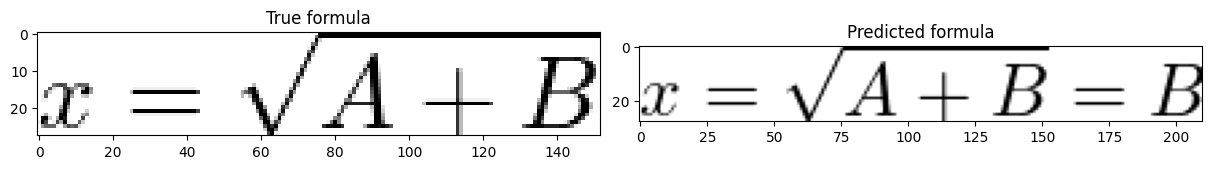

In [13]:
true_img, pred_img = make_pair('bbb', formulas[4])
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))
ax1.set_title('True formula')
ax1.imshow(true_img, cmap='gray')
ax2.set_title('Predicted formula')
ax2.imshow(pred_img, cmap='gray')
plt.show()